In [2]:
# Environment: minconda python 3.9.7

from DijkstraSolver import DijkstraSolver, singleAccessibilitySolve
from BasicSolver import BasicSolver
basicSolver = BasicSolver()

walkingDistanceLimit = 700
timeDeltaLimit = 180 * 60
walkingSpeed = 1.4
isRealTime = True

In [10]:
# Calculating OD matrix
startLocation = {
    "stop_lat": 39.963596, 
    "stop_lon": -83.000944
}
timestamp = 1517490000
args = {
    "timestamp": timestamp, 
    "walkingDistanceLimit": walkingDistanceLimit, 
    "timeDeltaLimit": timeDeltaLimit, 
    "walkingSpeed": walkingSpeed, 
    "isRealTime": isRealTime, 
}

solver, results = singleAccessibilitySolve(args, startLocation)


------ Retrospective Timetable Routing Running... ------


  0%|          | 0/3056 [00:00<?, ?it/s]

------ Retrospective Timetable Routing Finished... ------
------ Scheduled Timetable Routing Running... ------


  0%|          | 0/3056 [00:00<?, ?it/s]

------ Scheduled Timetable Routing Finished... ------
------ Realizable Timetable Routing Running... ------
------ Realizable Timetable Routing Finished... ------


In [4]:
# Produce buffers
location = r"D:\CURA\GRA\ACCESS\data"
location = r"C:\Users\liu.6544\Downloads\data"
from ipyleaflet import GeoJSON, Map
from ipywidgets import IntSlider
from shapely.geometry import Point, mapping
import json, sys
import pandas as pd
import geopandas as gpd
from tqdm.notebook import tqdm
timeBudgetList = list(range(5,121,5))
typeIDList = ["SC", "RT", "RV"]
typeIDMeaningDic = {
    "SC": "scheduled",
    "RT": "retrospective",
    "RV": "realizable"
}
colorList = ["blue", "green", "orange"]
colorDic = {}

for index in range(len(typeIDList)):
    colorDic[typeIDList[index]] = colorList[index]

columnsHead = ["lat", "lon"]
for typeID in typeIDList:
    for timeBudget in timeBudgetList:
        columnsHead.append(typeID + "_" + str(timeBudget))

parameterList = []
for receivingStopID, ODRecord in (results.items()):
    insertRecord = [float(ODRecord["stop_lat"]), float(ODRecord["stop_lon"])]
    for typeID in typeIDList:
        for timeBudget in timeBudgetList:
            if ODRecord["time" + typeID] == None:
                ODRecord["time" + typeID] = sys.maxsize
            radius = int(max(min((timeBudget * 60 - ODRecord["time" + typeID]) * walkingSpeed, walkingDistanceLimit), 0))
            insertRecord.append(radius)
    parameterList.append(insertRecord)

GDFList = {}
geojsonList = {}
df = pd.DataFrame(parameterList, columns = columnsHead)
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
df = df.drop(['lon', 'lat'], axis=1)
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)
gdf_p = gdf.to_crs("EPSG:32123")
for typeID in tqdm(typeIDList, position =0):
    for timeBudget in tqdm(timeBudgetList, position = 1):
        buffers = gdf_p.buffer(distance=df[typeID + "_" + str(timeBudget)])
        buffers_p = buffers.to_crs("EPSG:4326")
        buffer_gdf = gpd.GeoDataFrame(geometry=buffers_p)
        buffer_gdf = buffer_gdf.dissolve()
        GDFList[typeID + "_" + str(timeBudget)] = buffer_gdf
        geo_json = json.loads(buffer_gdf.to_json())
        
        geojsonLayer = GeoJSON(
            data=geo_json,
            style={
                "opacity": 1, "color": colorDic[typeID], "fillOpacity": 0.1, "fillColor": colorDic[typeID]
            }
        )
        geojsonList[typeID + "_" + str(timeBudget)] = geojsonLayer
        buffer_gdf.to_file(location + "\\PPA_" + typeIDMeaningDic[typeID] + "_" + str(timeBudget) + ".gpkg", driver="GPKG")
#         buffer_gdf.to_file(location + "\\PPA_" + typeIDMeaningDic[typeID] + "_" + str(timeBudget) + ".json", driver="GeoJSON")

# Visualizae PPA
from ipyleaflet import Map, basemaps, Circle, WidgetControl, GeoJSON, LayerGroup, GeoData
from ipywidgets import IntSlider, ColorPicker, jslink

defaultTimeBudget = 30
timeBudgetBackup = defaultTimeBudget

def onChange(e):
    timeBudget = int(e["new"])
    oldTimeBudget = int(e["old"])
    for typeID in typeIDList:
        m.add_layer(geojsonList[typeID + "_" + str(timeBudget)])
        m.remove_layer(geojsonList[typeID + "_" + str(oldTimeBudget)])
        
m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=(39.963596, -83.000944), zoom=11)
slider = IntSlider(min=5, max=120, step=5, value=defaultTimeBudget, continuous_update=True)
slider.observe(onChange, names='value')

for typeID in typeIDList:
    m.add_layer(geojsonList[typeID + "_" + str(defaultTimeBudget)])



widget_control1 = WidgetControl(widget=slider, position='topright')
m.add_control(widget_control1)

m


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Map(center=[39.963596, -83.000944], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [5]:
buffers = gdf_p.buffer(distance=df["SC" + "_120"])
buffer_gdf = gpd.GeoDataFrame(geometry=buffers)
buffer_gdf = buffer_gdf.dissolve()
buffer_gdf.area

0    5.178342e+08
dtype: float64

In [6]:
# Overlay analysis
jobsGDF = gpd.read_file(r"C:\Users\liu.6544\Downloads\data\columbus_jobs.gpkg", layer='Jobs')
jobsGDFList = []
jobsTotalNumber = len(jobsGDF)

typeIDList = ["SC", "RT", "RV"]
typeIDMeaningDic = {
    "SC": "scheduled",
    "RT": "retrospective",
    "RV": "realizable"
}
opportunityDic = {}
for typeID in typeIDList:
    opportunityDic[typeID] = []
for timeBudget in tqdm(timeBudgetList, position=0, leave=True):
    for typeID in typeIDList:
        jobsJoinedGDF = gpd.sjoin(jobsGDF, GDFList[typeID + "_" + str(timeBudget)], how="inner", op='intersects')
        jobsNumber = len(jobsJoinedGDF)
        opportunityDic[typeID].append(int(jobsNumber/jobsTotalNumber*10000)/100)
#         print("    " +  str(jobsNumber) + " jobs are accessible, which is " + str(int(jobsNumber/jobsTotalNumber*10000)/100) +"% of all Columbus jobs in the " + typeIDMeaningDic[typeID] + " scenario.")


  0%|          | 0/24 [00:00<?, ?it/s]

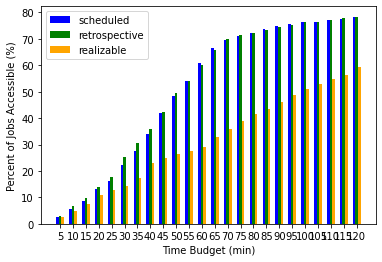

In [9]:
# importing package
import matplotlib.pyplot as plt
import numpy as np

# create data
x = np.arange(len(timeBudgetList))
width = 0.2
  
# plot data in grouped manner of bar type
for typeIDIndex in range(len(typeIDList)):
    typeID = typeIDList[typeIDIndex]
    
    plt.bar(x + width * (typeIDIndex - 1), opportunityDic[typeID], width, color=colorDic[typeID])
plt.xticks(x, timeBudgetList)
plt.xlabel("Time Budget (min)")
plt.ylabel("Percent of Jobs Accessible (%)")
plt.legend((typeIDMeaningDic.values()))
plt.show()